In [2]:
import numpy as np
import matplotlib.pyplot as plt
from models.analytical.trapdiffusion import TrapDiffusion, hadamard, SingleOccupationSingleIsotope
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Standard Trap-Diffusion Model

## Single-Occupation, Single Isotope Model

\begin{aligned}
&\begin{aligned}
\frac{d}{d t}\left(\begin{array}{c}
c_s \\
c_{t, 1} \\
c_{t, 2}
\end{array}\right) & =\left(\begin{array}{l}
1 / c^S \\
1 / c_1^T \\
1 / c_2^T
\end{array}\right) \circ \\
& \left\{\left(\begin{array}{ccc}
-\left(a_{T_1 S} c_1^T \sigma+a_{T_2 S} c_2^T \sigma\right) c^S & a_{S T_1} c_1^T & a_{S T_2} c_2^T \\
a_{T_1 S} c^S c_1^T \sigma & -a_{S T_1} c_1^T & 0 \\
a_{T_2 S} c^S c_2^T \sigma & 0 & -a_{S T_2} c_2^T
\end{array}\right)\left(\begin{array}{c}
c_s \\
c_{t, 1} \\
c_{t, 2}
\end{array}\right)\right.
\end{aligned}\\
&\left.+\left[\left(\begin{array}{c}
c_s \\
c_{t, 1} \\
c_{t, 2}
\end{array}\right) \circ\left(\begin{array}{ccc}
0 & \frac{a_{T_1 s} s^S c_1^T \sigma}{c_{t, 1}^{M a x}} & \frac{a_{T_2 s} s^S c_2^T \sigma}{c_{t, 2}^{M a x}} \\
-\frac{a_{T_1 s} c^s c_1^T \sigma}{c_{t, 1}^{M a x}} & 0 & 0 \\
-\frac{a_{T_2 s} c^T c_2^T \sigma}{c_{t, 2}^{M a x}} & 0 & 0
\end{array}\right)\left(\begin{array}{c}
c_s \\
c_{t, 1} \\
c_{t, 2}
\end{array}\right)\right]\right\}
\end{aligned}

$$
\begin{equation}
\frac{d}{d t} \vec{c}_{s, t}=\left(\frac{1}{\vec{c}^{ S / T}}\right) \circ\left[\underline{\underline{\mathbf{A}}} \vec{c}_{s, t}+\vec{c}_{s, t} \circ \underline{\underline{\mathbf{B}}} \vec{c}_{S, t}\right] .
\end{equation}
$$

$$
\begin{equation}
\underline{\underline{\mathbf{A}}}=\underline{\underline{\tilde{A}}} \underline{\underline{\mathbf{C}}}=\left(\begin{array}{ccc}
-\left(a_{T_1 S} c_1^T \sigma+a_{T_2 S} c_2^T \sigma\right) & a_{S T_1} & a_{S T_2} \\
a_{T_1 S} c_1^T \sigma & -a_{S T_1} & 0 \\
a_{T_2} s c_2^T \sigma & 0 & -a_{S T_2}
\end{array}\right)\left(\begin{array}{ccc}
c^S & 0 & 0 \\
0 & c_1^T & 0 \\
0 & 0 & c_2^T
\end{array}\right)
\end{equation}
$$

- $c_{t,i}$ : concentration of hydrogen trapped in trap of type i
- $c_j^T$ : concentration of traps of type j
- $c_{s}$ : concentration of solute hydrogen in non-trap (solute) sites
- $c^S$ : concentration of solute sites
- $a_{i\leftarrow j}$ : transition rate from j to i, typically in matrix notation in row i and columnn j
- $c_{t,i}^{Max} $ : the upper limit (maximum) of the hydrogen concentration which can be trapped in a trap of type i (capacity limit of trap)
- $\sigma$ : capture cross-section of a trap-site

## TODO

solute in steady state auf 0
-> outflow aus den traps

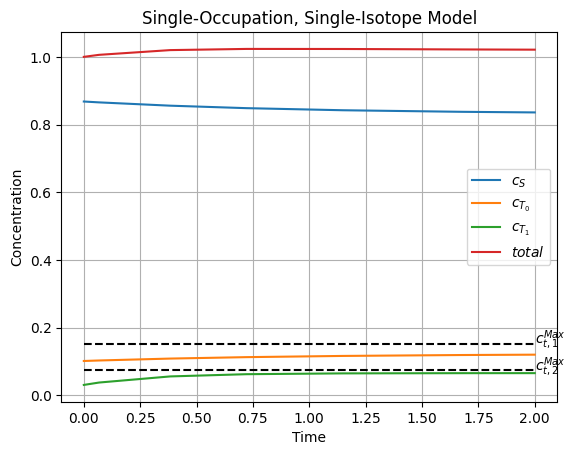

In [6]:
np.random.seed(1)
s = SingleOccupationSingleIsotope(2)
s.plot()

## Single-Occupation, Multiple Isotope Model

In [ ]:
class SingleOccupationMultipleIsotope(TrapDiffusion):
    def __init__(self, n_traps = 2, n_isotopes = 2):
        TrapDiffusion.__init__(self, "Single-Occupation, Multiple-Isotope Model")
        # concentraion of trap sites and solute sites.
        # c_S_T = [c_S, c_T_1, c_T_2, ...]

        self.c_S_T = np.random.random(n_traps + 1)
        self.c_S_T = self.c_S_T / np.sum(self.c_S_T)
        c_S = self.c_S_T[0]

        # site concentration matrix
        self.C = np.diag(self.c_S_T)

        # max trap conentration, has to be greater than current concentration
        self.c_Max = np.random.random(n_traps)
        self.c_Max = self.c_Max * 0.5

        # capture cross-section of trap-site
        self.sigma = 1

        # base transition rates
        self.a = np.random.random((n_traps+1,n_traps+1))

        # transition rate matrix
        # trap to trap terms on the diagonal, (0,0) will be overwritten
        self.A_tilde = np.diag(-self.a[0,:])

        # solute's losses (0,0)
        # sigma is constant for all traps at the moment, so can be factored out
        self.A_tilde[0,0] = -self.sigma * np.sum(self.a[1:,0] * self.c_S_T[1:])
        
        # trap's gains from solute (first column)
        self.A_tilde[1:,0] = self.a[1:,0] * self.c_S_T[1:] * self.sigma

        # solutes gain from traps (first row)
        self.A_tilde[0,1:] = self.a[0,1:]

        self.A = self.A_tilde @ self.C

        self.B = np.zeros((n_traps+1,n_traps+1))

        # first row
        self.B[0,1:] = self.a[1:,0] * self.c_S_T[1:] * c_S * self.sigma / self.c_Max
        # fill in anty-symmetric part
        self.B[:, 0] = -self.B[0,:]


        # random start concentrations
        self.c = np.random.random((n_traps+1)*n_isotopes)
        for i in range(n_isotopes):
            self.c[i*(n_traps+1)] = 
        self.c[1:] *=self.c_Max/n_isotopes
        self.c[0] = 1 - np.sum(self.c[1:]) 

    def rhs(self,c,t):
        return hadamard(1/self.c_S_T, self.A@c + hadamard(c,self.B@c))

    def jacobian(self,c,t):
        return hadamard(1/self.c_S_T, self.A + self.B@c + hadamard(c,self.B))
    
    @property
    def vector_description(self):
        desc = {
            0: "$c_S$",
        }
        for i in range(1, len(self.c)):
            desc[i] = f"$c_{{T_{i-1}}}$"
        return desc
    
    def plot_details(self):
        for i, cm in enumerate(self.c_Max):
            plt.hlines([cm], 0, self.ts[-1], linestyles = "dashed", color = "black")
            plt.text(self.ts[-1], cm, f"$c^{{Max}}_{{t,{i+1}}}$")
